In [127]:
import pandas as pd
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [128]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, r2_score

In [129]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import os

In [132]:
%store -r df_Xy

In [133]:
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 363 entries, gbp_rate to gold_dif_lag10
dtypes: float64(363)
memory usage: 8.4 MB


# We want to investigate the predictivty of central bank policy rates and stock market index performance as they relate to the price of gold. 
## The core question here is if the addition of central bank rates and stock market indices to a model can outperform a model that only uses gold's price and an up to a 10 period lag as a features.

## We'll attempt to use time series modeling to predict the daily price, daily price difference, and daily percent change in price of gold.
### We have the most recent 10 years of daily data from the following sources:
### Features:
#### Top 5 equity market indices by market capitalization, per Statista: https://www.statista.com/statistics/270126/largest-stock-exchange-operators-by-market-capitalization-of-listed-companies/, and their corresponding daily performance and percent change
NYSE Composite Index history: https://finance.yahoo.com/quote/%5ENYA?p=^NYA&.tsrc=fin-srch
NASDAQ Composite Index history: https://finance.yahoo.com/quote/%5EIXIC?p=^IXIC&.tsrc=fin-srch
Japan Exchange Group Composite Index history: https://finance.yahoo.com/quote/8697.T?p=8697.T&.tsrc=fin-srch
Shanghai Stock Exchange Composite Index history: https://finance.yahoo.com/quote/%5ESSEC?p=^SSEC&.tsrc=fin-srch
Hang Seng (Hong Kong) Index History: https://finance.yahoo.com/quote/%5EHSI?p=^HSI&.tsrc=fin-srch
#### Top 5 Currencies Globally in Forex Trading (https://www.ig.com/us/trading-strategies/top-10-most-traded-currency-pairs-191206), and their corresponding daily central bank policy rates and percent change
The Fed (USD): https://fred.stlouisfed.org/series/FEDFUNDS
ECB (EUR): https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html
BoJ (JPY): https://fred.stlouisfed.org/series/IRSTCI01JPM156N
United Kingdom (GBP): https://fred.stlouisfed.org/series/GBPONTD156N
Australia (AUD): https://www.rba.gov.au/statistics/cash-rate/
#### Daily price of gold  and percent change (up to 10-day lag): https://www.usagold.com/reference/prices/goldhistory.php

### Targets:
#### Daily price of gold, daily difference in gold price, daily percent change price of gold: https://www.usagold.com/reference/prices/goldhistory.php

## As the data sits, we currently have both daily policy rates and index scores (along with differences and percent changes) - each with up to a ten day lag on the data. This translates to  121 features each in our 3 would-be models (daily price, daily price difference, daily percent price change).

### Let's start by separating our data

In [134]:
# store column titles to create separate dataframes for raw values, differences, and percent changes

col_raw = []
col_dif = []
col_change = []

for col in df_Xy.columns:
    if 'change%' in col:
        col_change.append(col)
    elif 'dif' in col:
        col_dif.append(col)
    else:
        col_raw.append(col)

In [135]:
# create three separate dataframes, one with raw values, one with differences, and one with percent change

df_Xy_raw = df_Xy[col_raw].dropna()

df_Xy_dif = df_Xy[col_dif].dropna()

df_Xy_change = df_Xy[col_change].dropna()

In [136]:
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3022 entries, 2008-09-19 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [137]:
df_Xy_dif.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_dif to gold_dif_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [138]:
df_Xy_dif.reset_index(inplace = True)

In [139]:
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


#### To compare models on a level playing field, we need to ensure the same date range is being used for both the raw and the change data. Let's take a look at the date ranges in all of our datasets. It looks like our difference dataframe is the limiting factor here with '2008-09-22' being the earliest date in the dataset.

In [140]:
df_Xy_raw = df_Xy_raw[df_Xy_raw.index >= '2008-09-22']
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [141]:
df_Xy_raw.reset_index(inplace = True)

In [142]:
df_Xy_change = df_Xy_change[df_Xy_change.index >= '2008-09-22']
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [143]:
df_Xy_change.reset_index(inplace = True)

In [144]:
# create X,y pairs for both raw and percent change dataframes

X_raw = df_Xy_raw.drop(columns = ['gold'])
y_raw = df_Xy_raw['gold']

X_dif = df_Xy_dif.drop(columns = ['gold_dif'])
y_dif = df_Xy_dif['gold_dif']

X_change = df_Xy_change.drop(columns = ['gold_change%'])
y_change = df_Xy_change['gold_change%']

## EDA
### Historical Gold Data Trends and Moving Averages

In [145]:
# We default the window here to 365 as we have daily data, and we want to average-out seasonal patterns, if they exist
def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

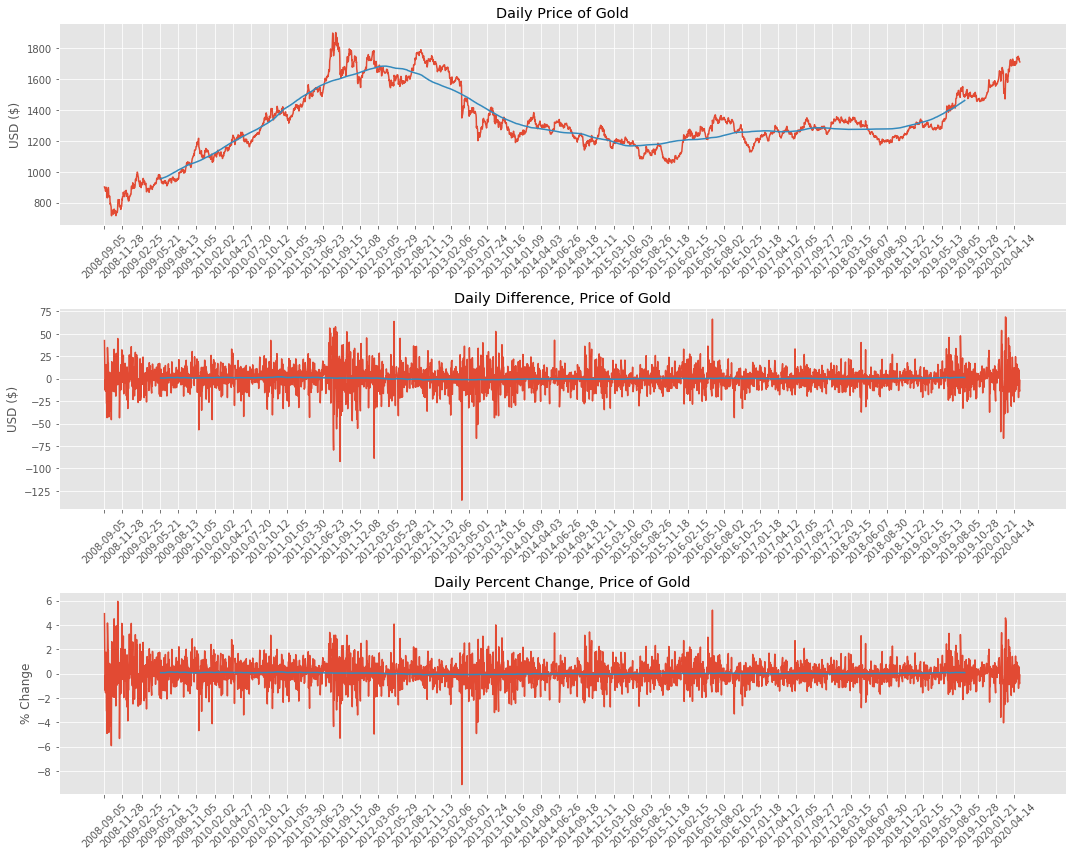

In [146]:
fig,axs = plt.subplots(3,1, figsize = (15,12))

for ax,metric,series in zip(axs,[('Daily Price of Gold','USD ($)'), ('Daily Difference, Price of Gold','USD ($)'),\
                            ('Daily Percent Change, Price of Gold','% Change')],[y_raw,y_dif,y_change]):
        
        ma = fit_moving_average_trend(series)
        ax.plot(df_Xy.index[series.index],series)
        ax.plot(df_Xy.index[series.index],ma, label = 'Moving Average')
        ax.set_title(metric[0])
        ax.set_ylabel(metric[1])
        ax.set_xticks(df_Xy.index[series.index][::60])
        ax.xaxis.set_tick_params(rotation=45)
        
       
plt.tight_layout()        

## EDA
### Historical Gold Data Trends Alongside All Features

In [161]:
# raw data

col_lag = ['date','gold']
for col in df_Xy_raw.columns:
    if 'lag' in col:
        col_lag.append(col)
        
X_nolag_raw = df_Xy_raw.drop(columns = col_lag)


In [195]:
def plot_trends(X,y):
    
    """
    PARAMETERS:
    
    X - pandas Dataframe equivalent to feature matrix
    y- pandas Series equivalent to target
    """
    
    y_label = input('What is your Target? Include Units ')



    fig, axs = plt.subplots(len(X.columns), figsize = (15,30))

    for col, ax in zip(X.columns,axs):
    
        tgt = y
        series = X[col]

        ax.plot(df_Xy.index[series.index],series, label = col)

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis


        ax2.set_ylabel(y_label, fontsize = 8)  # we already handled the x-label with ax1
        ax2.plot(df_Xy.index[tgt.index],tgt, color = 'blue', alpha = 0.5, label = 'gold')

        ax2.tick_params(axis='y', labelcolor='blue')


        ax.set_title(f'{col} vs Price of Gold, Historical')
        
        if 'rate' in col:
            ax.set_ylabel(f'{col} (%)', fontsize = 8)

        else:
            ax.set_ylabel(f'{col} (Index Score)', fontsize = 8)
        
        ax.legend()
        ax2.legend()
    
    plt.tight_layout()

What is your Target? Include Units Daily Price of Gold ($USD)
Is Your Data Transformed? How so? 


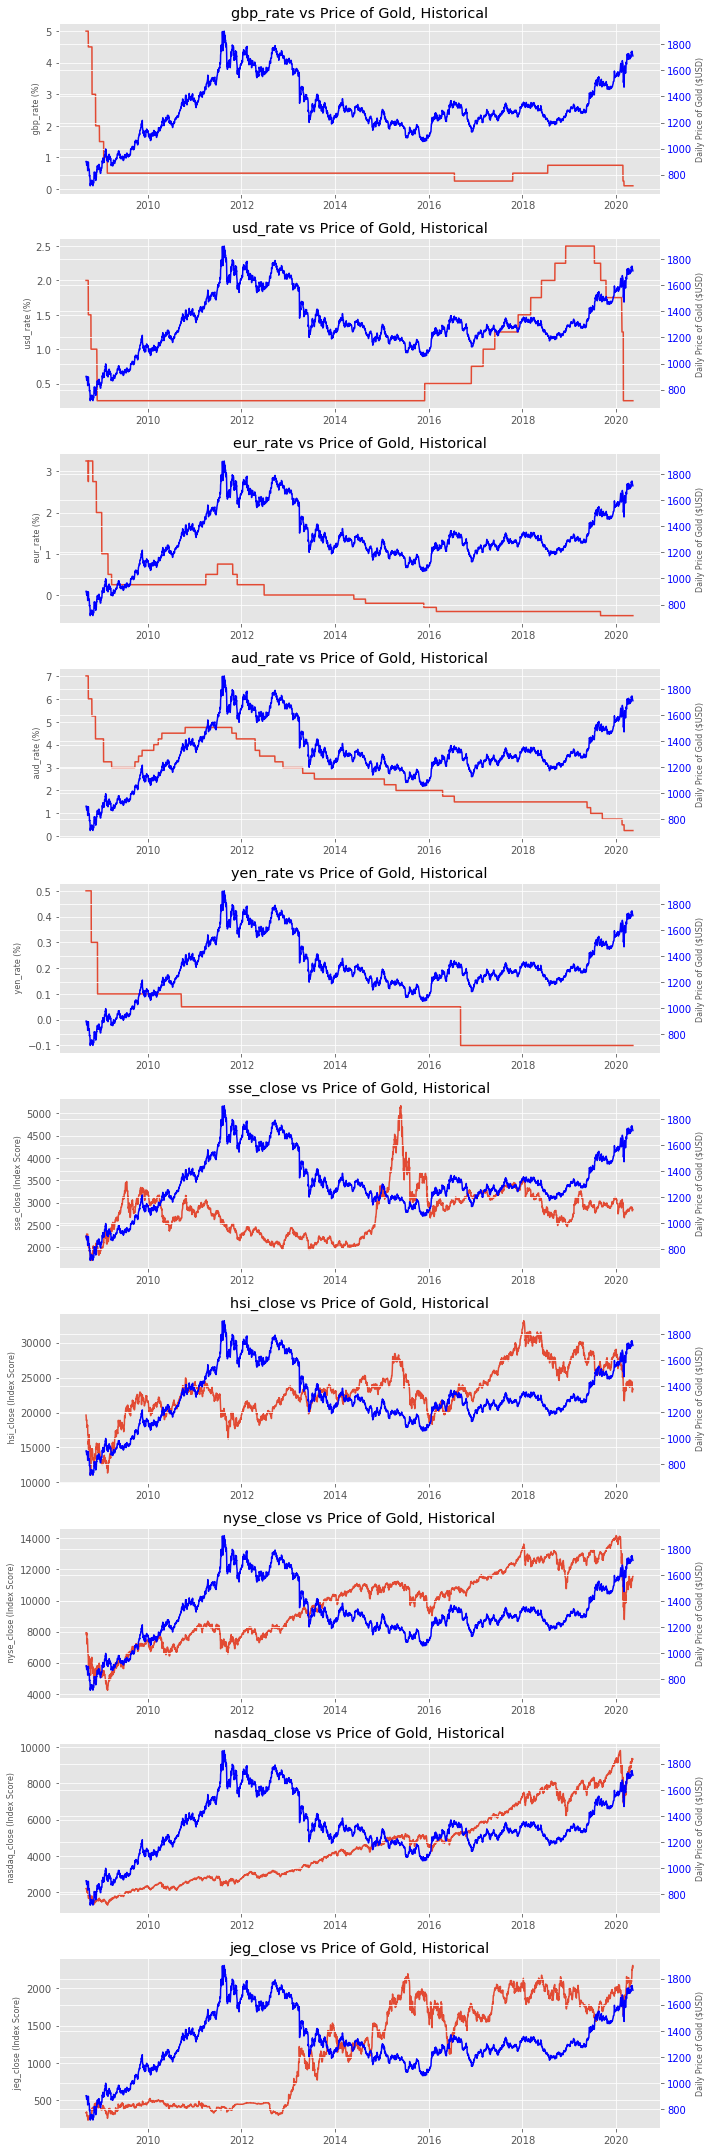

In [184]:
plot_trends(X_nolag_raw,y_raw)

### Raw Data Trends - Price of Gold, Central Bank Policy Rates, and Global Index Summary:
While there are periods of time within the data the gold moves in tandem with our features, those trends and not consistent throughout our entire time window of the most recent ten years.

Rates that stick out to me: Euro, Australian Dollar
Stock indices that stick out to me: Nasdaq, NYSE

#### Idea: Let's see if these trends are upheld for both the daily difference in price and daily percent change in price

In [185]:
# difference data

col_lag = ['date','gold_dif']
for col in df_Xy_dif.columns:
    if 'lag' in col:
        col_lag.append(col)
        
X_nolag_dif = df_Xy_dif.drop(columns = col_lag)

What is your Target? Include Units Daily Gold Price Difference ($USD)


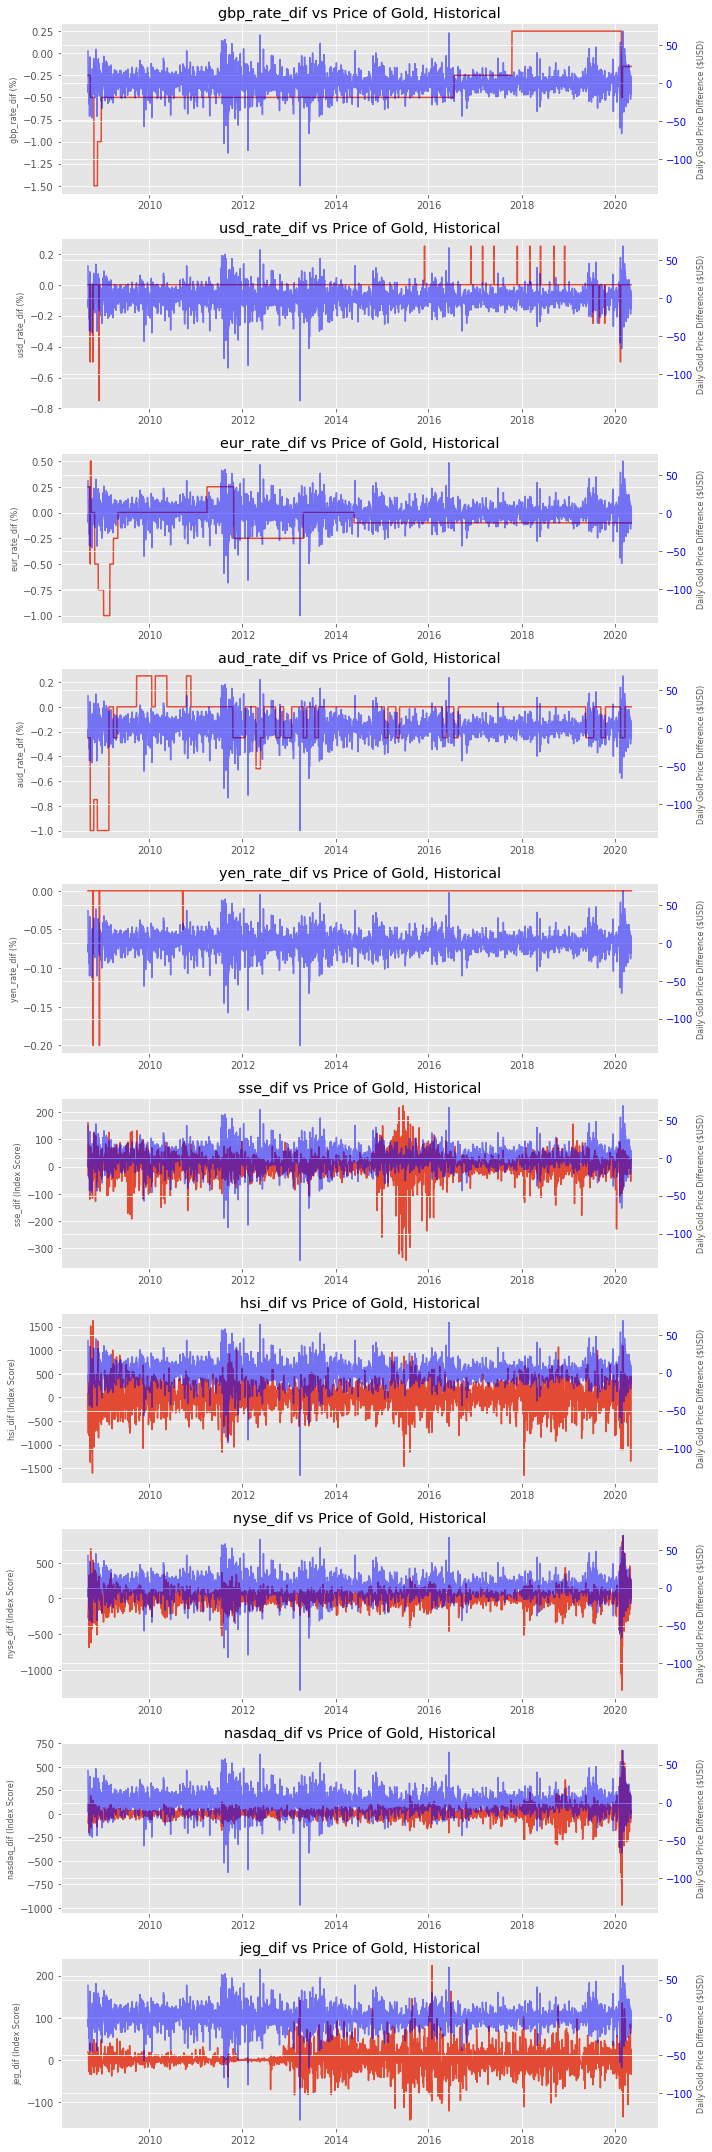

In [189]:
plot_trends(X_nolag_dif, y_dif)

In [193]:
# difference data

col_lag = ['date','gold_change%']
for col in df_Xy_change.columns:
    if 'lag' in col:
        col_lag.append(col)
        
X_nolag_change = df_Xy_change.drop(columns = col_lag)

What is your Target? Include Units Daily Gold Price Percent Change


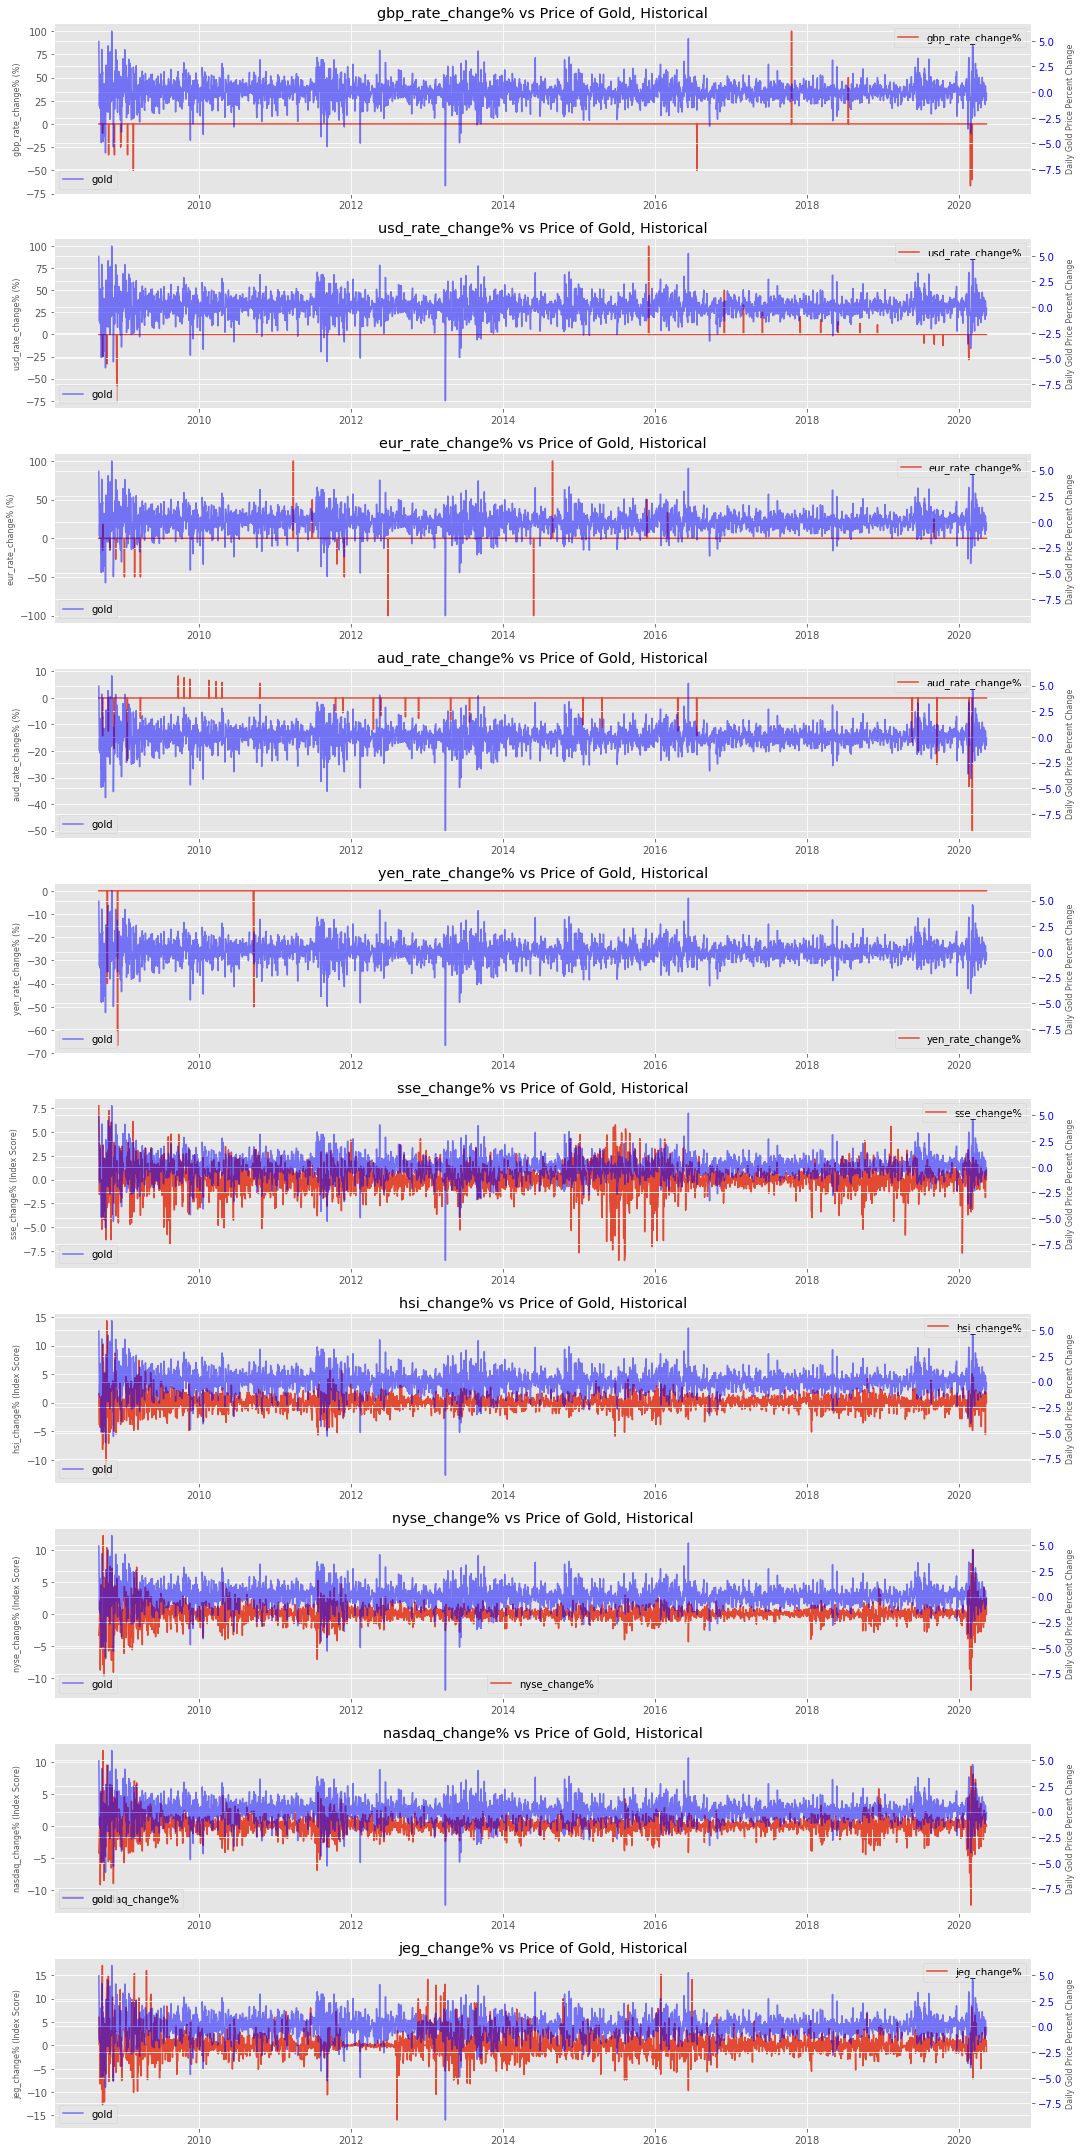

In [196]:
plot_trends(X_nolag_change, y_change)

## EDA
### Testing for Stationarity with Augmented Dickey Fuller

In [20]:
for title, series in zip(['Daily Price of Gold', 'Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_raw,y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    print(f'{title} ADF p-value: {round(test[1],3)}')

Daily Price of Gold ADF p-value: 0.397
Daily Difference, Price of Gold ADF p-value: 0.0
Daily Percent Change, Price of Gold ADF p-value: 0.0


So we now know that both gold's Daily Price Difference and Daily Percent Change are stationary.
Let's take a look at some autocorrelation and partial autocorrelation plots to see if an AR (auto-regressive) model  would make sense for our baselines

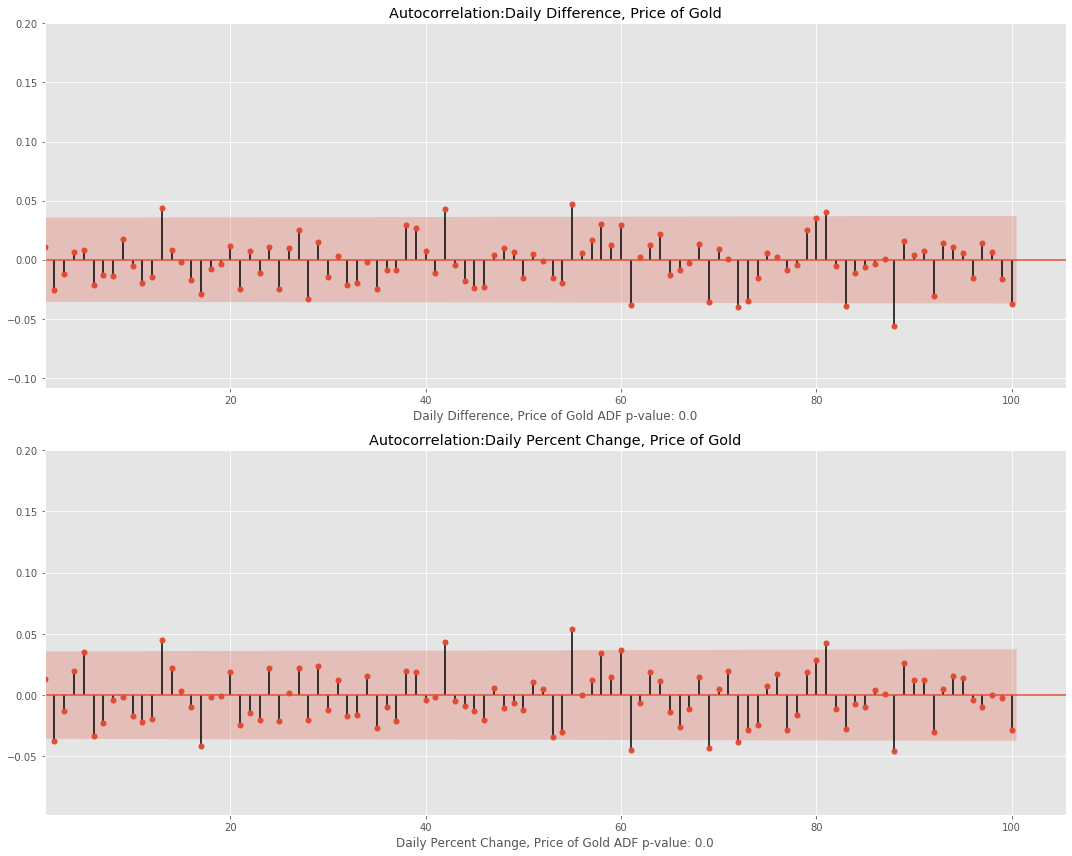

In [21]:
fig, axs = plt.subplots(2, figsize=(15, 12))

for ax, title, series in zip(axs, ['Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    
    sm.graphics.tsa.plot_acf(series, lags=100, ax=ax)
    ax.set_title(f'Autocorrelation:{title}')
    
    # The zeroth value in these graphs is pointless (a dataset is perfectly correlated to itself)
    ax.set_xlim(left = 1)
    ax.set_ylim(top = 0.2)
    ax.set_xlabel(f'{title} ADF p-value: {round(test[1],3)}')

plt.tight_layout()

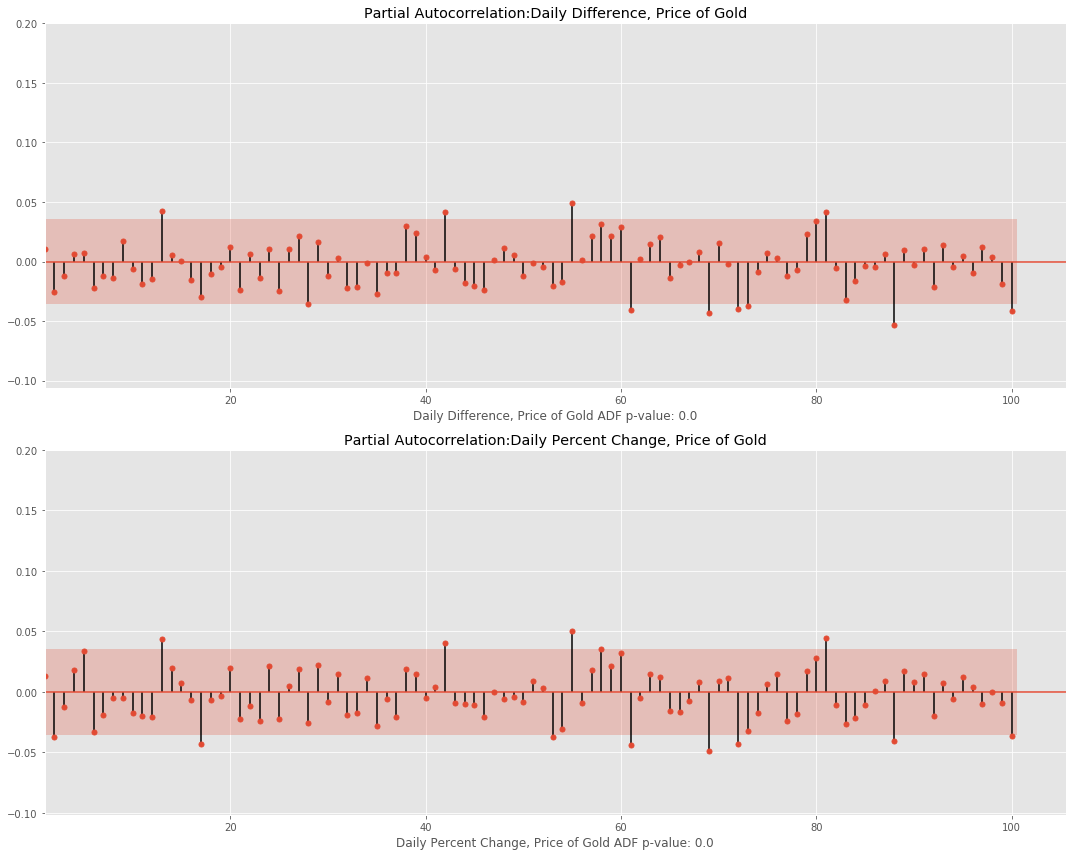

In [22]:
fig, axs = plt.subplots(2, figsize=(15, 12))

for ax, title, series in zip(axs, ['Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    
    sm.graphics.tsa.plot_pacf(series, lags=100, ax=ax)
    ax.set_title(f'Partial Autocorrelation:{title}')
    
    # The zeroth value in these graphs is pointless (a dataset is perfectly correlated to itself)
    ax.set_xlim(left = 1)
    ax.set_ylim(top = 0.2)
    ax.set_xlabel(f'{title} ADF p-value: {round(test[1],3)}')

plt.tight_layout()

### While we've proven stationarity in daily price difference and daily percent change, our Autocorrelation plots leave a lot to be desired. An AR based model doesn't seem like the proper approach, but linear regression actually assumes an absence of autocorrelation. To get the simplest of baselines, let's fit a linear model with gold's price difference and price change with the features being a 1 through 10 day lag.

## Linear Model Assumptions:
- Linear relationship - check with scatters and pearsonr tests
- Errors are normally distributed
- Homoscedasticity of errors (or, equal variance around the line) - fit a model and visualize
- Independence of the observations - We may be breaking the rules a bit here. We're realing most concerned with generating a baseline model. 

In [23]:
# generate gold difference and gold % change dfs with lag

#Difference
col_gold_dif = []
for col in X_dif.columns:
    if 'gold' in col:
        col_gold_dif.append(col)

X_dif_gold = X_dif[col_gold_dif]
X_dif_gold.info()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gold_dif_lag1   3021 non-null   float64
 1   gold_dif_lag2   3021 non-null   float64
 2   gold_dif_lag3   3021 non-null   float64
 3   gold_dif_lag4   3021 non-null   float64
 4   gold_dif_lag5   3021 non-null   float64
 5   gold_dif_lag6   3021 non-null   float64
 6   gold_dif_lag7   3021 non-null   float64
 7   gold_dif_lag8   3021 non-null   float64
 8   gold_dif_lag9   3021 non-null   float64
 9   gold_dif_lag10  3021 non-null   float64
dtypes: float64(10)
memory usage: 236.1 KB


In [24]:
#Percent Change
col_gold_change = []
for col in X_change.columns:
    if 'gold' in col:
        col_gold_change.append(col)

X_change_gold = X_change[col_gold_change]
X_change_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gold_change%_lag1   3021 non-null   float64
 1   gold_change%_lag2   3021 non-null   float64
 2   gold_change%_lag3   3021 non-null   float64
 3   gold_change%_lag4   3021 non-null   float64
 4   gold_change%_lag5   3021 non-null   float64
 5   gold_change%_lag6   3021 non-null   float64
 6   gold_change%_lag7   3021 non-null   float64
 7   gold_change%_lag8   3021 non-null   float64
 8   gold_change%_lag9   3021 non-null   float64
 9   gold_change%_lag10  3021 non-null   float64
dtypes: float64(10)
memory usage: 236.1 KB


## Linear Regression Model: Daily Gold Price Difference (USD), 10 day lag

In [25]:
from sklearn.linear_model import LinearRegression

Because we're using time series based data, our train-test split will need to ensure that our data stays chronological.

In [26]:
from sklearn.model_selection import TimeSeriesSplit

In [27]:
tscv = TimeSeriesSplit()

In [28]:
train_X_dif_gold = X_dif_gold[:int(X_dif_gold.shape[0]*0.7)]
test_X_dif_gold = X_dif_gold[int(X_dif_gold.shape[0]*0.7):]
train_y_dif = y_dif[:int(X_dif_gold.shape[0]*0.7)]
test_y_dif = y_dif[int(X_dif_gold.shape[0]*0.7):]

#### Cross Validation: Linear Regression of Daily Price Difference (USD), 10 day lag

In [29]:
def cross_val_and_score(model,X_train, X_test, y_train, y_test):
    
    
    """
    PARAMETERS:
    model - unfit scikit learn model object
    X_train - Training feature dataset in pandas DataFrame
    X_test - Test feature dataset in pandas series
    y_train - Training target dataset in pandas DataFrame
    y_test - Test target dataset in pandas series
    
    RETURNS:
    numpy array of cross_validation and final train/test score
    
    """
    
    tscv = TimeSeriesSplit()
    
    score_label = ''
    
    if 'class' in str(model).lower():
        score_label = 'Model Accuracy Score'
    else:
        score_label = 'Model R^2 Score'
        
    
    score = []
    count = 1
    for tr_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.loc[tr_index], X_train.loc[val_index]
        y_tr, y_val = y_train.loc[tr_index], y_train.loc[val_index]
        
        m_dif = model
    
        m_dif.fit(X_tr,y_tr)
        
        score_ = m_dif.score(X_val,y_val)
    
        score.append(score_)
        print(f'Cross_Val {count} {score_label}:{round(score_,3)}')
        count += 1

    m_dif = model
    m_dif.fit(X_train,y_train)
    
    score_ = m_dif.score(X_test,y_test)
    score.append(score_)
    print(f'Final {score_label}:{round(score_,3)}')
    return score, m_dif

In [80]:
# Instantiate dictionary to store all model scores
d_score = dict()

In [81]:
dif_gold_score, dif_gold_model = cross_val_and_score(LinearRegression(),train_X_dif_gold, test_X_dif_gold, train_y_dif, test_y_dif)

Cross_Val 1 Model R^2 Score:-0.021
Cross_Val 2 Model R^2 Score:-0.02
Cross_Val 3 Model R^2 Score:-0.016
Cross_Val 4 Model R^2 Score:-0.035
Cross_Val 5 Model R^2 Score:-0.014
Final Model R^2 Score:-0.008


In [82]:
d_score['Linear Regression of Daily Price Difference (USD), 10 day lag']:dif_gold_score

In [31]:
def plot_model(model,X_test,y_test):

    """PARAMETERS:
    model - scikit learn model object, fit with training data
    X_test - Test feature dataset in pandas DataFrame
    y_test - Test target dataset in pandas Series
    
    RETURNS:
    Plots predictions on top of values in time series plot in matplotlib
    """
    

    title = input('What is this model called?: ')
    y_label = input('What is your target variable?: ')
    
    fig,ax = plt.subplots(figsize = (15,12))
    
    ax.plot(df_Xy.index[X_test.index],model.predict(X_test), label = 'Predicted')
    ax.plot(df_Xy.index[y_test.index], y_test, label = 'Actual', alpha = 0.5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

What is this model called?: Linear Regression Model: Daily Gold Price Difference, 10 day lag
What is your target variable?: Daily Gold Price Difference


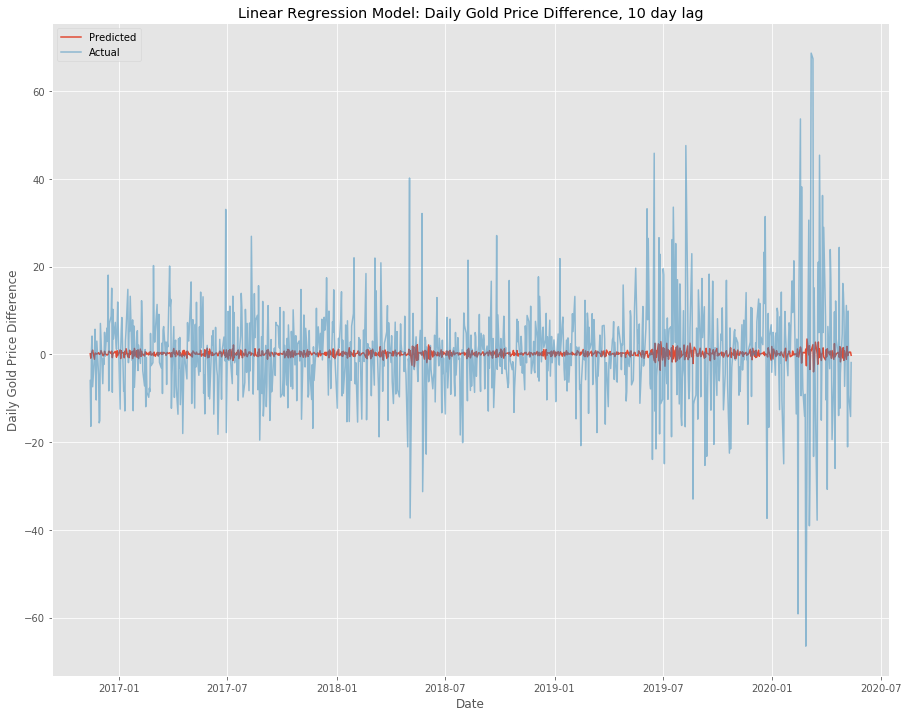

In [32]:
plot_model(dif_gold_model,test_X_dif_gold,test_y_dif)


### Linear Regression Model: Daily Gold Price Percent Change, 10 day lag

In [33]:
tscv = TimeSeriesSplit()
train_X_change_gold = X_change_gold[:int(X_change_gold.shape[0]*0.7)]
test_X_change_gold = X_change_gold[int(X_change_gold.shape[0]*0.7):]
train_y_change = y_change[:int(X_change_gold.shape[0]*0.7)]
test_y_change = y_change[int(X_change_gold.shape[0]*0.7):]

#### Cross Validation: Linear Regression of Daily Gold Price Percent Change, 10 day lag

In [34]:
change_gold_score, change_gold_model = cross_val_and_score(LinearRegression(),train_X_change_gold, test_X_change_gold, train_y_change, test_y_change)

Cross_Val 1 Model R^2 Score:-0.065
Cross_Val 2 Model R^2 Score:-0.022
Cross_Val 3 Model R^2 Score:-0.022
Cross_Val 4 Model R^2 Score:-0.036
Cross_Val 5 Model R^2 Score:-0.011
Final Model R^2 Score:-0.019


In [83]:
d_score['Linear Regression Model: Daily Gold Price Percent Change, 10 day lag'] = change_gold_score

What is this model called?: Linear Regression of Daily Gold Price Percent Change, 10 day lag
What is your target variable?: Daily Gold Price Percent Change


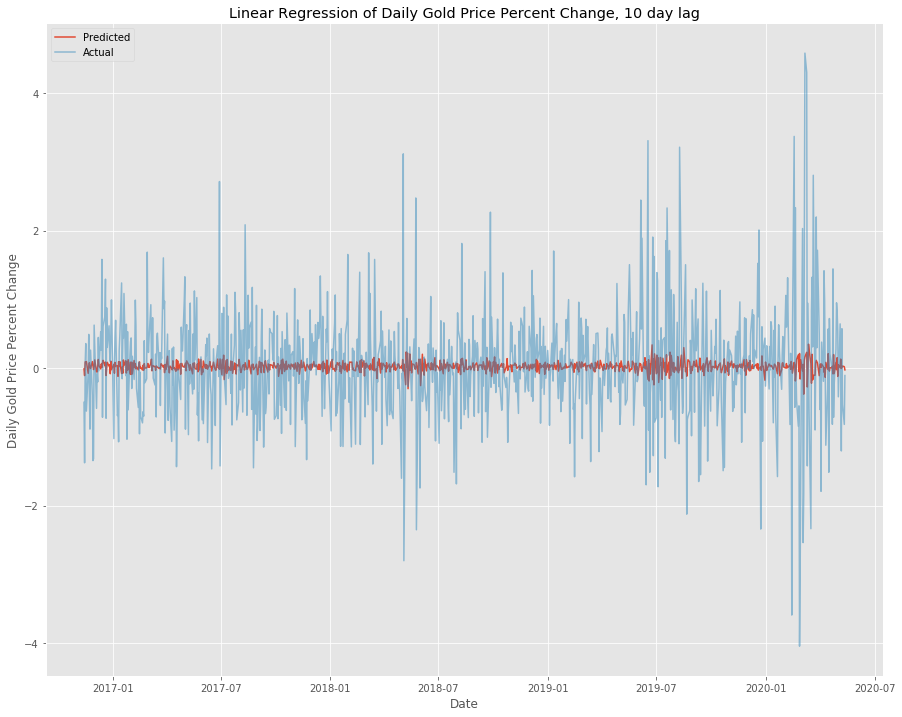

In [35]:
plot_model(change_gold_model,test_X_change_gold,test_y_change)


### Linear Regression for Gold Price 10 Day Lag Summary:
A simple linear model is doing more harm than good when using a ten day lag to predict both the Daily Price Difference (R^2 Score = -0.008) as well as the Daily Percent Change in Price (R^2 Score = -0.019).

#### Idea: Let's tryout a different model with again just the 10 day lag for only gold price data. A moving average feels like the logical next step, given its prominence as a technical indicator in the world of online trading. 

## 10 Day Moving Average Regressor: Daily Gold Price Difference (USD)

In [36]:
X_dif_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gold_dif_lag1   3021 non-null   float64
 1   gold_dif_lag2   3021 non-null   float64
 2   gold_dif_lag3   3021 non-null   float64
 3   gold_dif_lag4   3021 non-null   float64
 4   gold_dif_lag5   3021 non-null   float64
 5   gold_dif_lag6   3021 non-null   float64
 6   gold_dif_lag7   3021 non-null   float64
 7   gold_dif_lag8   3021 non-null   float64
 8   gold_dif_lag9   3021 non-null   float64
 9   gold_dif_lag10  3021 non-null   float64
dtypes: float64(10)
memory usage: 236.1 KB


In [37]:
y_dif_ma = X_dif_gold.mean(axis = 1)

In [38]:
y_dif = df_Xy_dif['gold_dif']

In [39]:
# Since we're taking a simple moving average, we don't need to split our feature matrices. We can just compare our moving averages to actual values
train_y_dif_ma = y_dif_ma[:int(X_dif_gold.shape[0]*0.7)]
test_y_dif_ma = y_dif_ma[int(X_dif_gold.shape[0]*0.7):]


train_y_dif = y_dif[:int(X_dif_gold.shape[0]*0.7)]
test_y_dif = y_dif[int(X_dif_gold.shape[0]*0.7):]

#### Cross Validation: 10 Day Moving Average Regression Daily Gold Price Difference (USD)

In [40]:
def cross_val_and_score_ma(y_ma_train, y_train, y_ma_test, y_test):
    
    
    """
    PARAMETERS:
    
    y_ma - Moving average to compare against target in pandas series format
    y_test - Test target dataset in pandas series format
    
    RETURNS:
    numpy array of cross_validation and final train/test score
    
    """
    
    tscv = TimeSeriesSplit()
    
    ma_type = input('Is this moving average a classifier(enter "c") or regressor(enter "r")?')
    
    score_label = ''
    
    score = []
    count = 1
    
    if ma_type == 'c':
        score_label = 'Model Accuracy Score'
        
        for tr_index, val_index in tscv.split(y_train):
            y_ma_tr, y_ma_val = y_ma_train.loc[tr_index], y_ma_train.loc[val_index]
            y_tr, y_val = y_train.loc[tr_index], y_train.loc[val_index]
        
            score_ = accuracy_score(y_val, y_ma_val)
            score.append(score_)
            print(f'Cross_Val {count} {score_label}:{round(score_,3)}')
            count += 1


        
        score_ = accuracy_score(y_test,y_ma_test)
        score.append(score_)
        print(f'Final {score_label}:{round(score_,3)}')
        return score
    else:
        score_label = 'Model R^2 Score'
        
        for tr_index, val_index in tscv.split(y_train):
            y_ma_tr, y_ma_val = y_ma_train.loc[tr_index], y_ma_train.loc[val_index]
            y_tr, y_val = y_train.loc[tr_index], y_train.loc[val_index]
        
            score_ = r2_score(y_val,y_ma_val)
            score.append(score_)
            print(f'Cross_Val {count} {score_label}:{round(score_,3)}')
            count += 1


        
        score_ = r2_score(y_test,y_ma_test)
        score.append(score_)
        print(f'Final {score_label}:{round(score_,3)}')
        return score
    
    
    



In [84]:
ma_dif_gold_score = cross_val_and_score_ma(train_y_dif_ma,train_y_dif,test_y_dif_ma,test_y_dif)

Is this moving average a classifier(enter "c") or regressor(enter "r")?r
Cross_Val 1 Model R^2 Score:-41.502
Cross_Val 2 Model R^2 Score:-169.434
Cross_Val 3 Model R^2 Score:-127.337
Cross_Val 4 Model R^2 Score:-49.557
Cross_Val 5 Model R^2 Score:-59.907
Final Model R^2 Score:-43.926


In [85]:
d_score['10 Day Moving Average Regressor: Daily Gold Price Difference (USD)'] = ma_dif_gold_score

In [42]:
def plot_ma_model(y_ma,y_test):

    """PARAMETERS:
    model - scikit learn model object, fit with training data
    X_test - Test feature dataset in pandas DataFrame
    y_test - Test target dataset in pandas Series
    
    RETURNS:
    Plots predictions on top of values in time series plot in matplotlib
    """
    

    title = input('What is this model called?: ')
    y_label = input('What is your target variable?: ')
    
    fig,ax = plt.subplots(figsize = (15,12))
    
    ax.plot(df_Xy.index[y_ma.index],y_ma, label = 'Predicted')
    ax.plot(df_Xy.index[y_test.index], y_test, label = 'Actual', alpha = 0.5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

What is this model called?: 10 Day Moving Average Regressor: Daily Gold Price Difference
What is your target variable?: Daily Gold Price Difference ($USD)


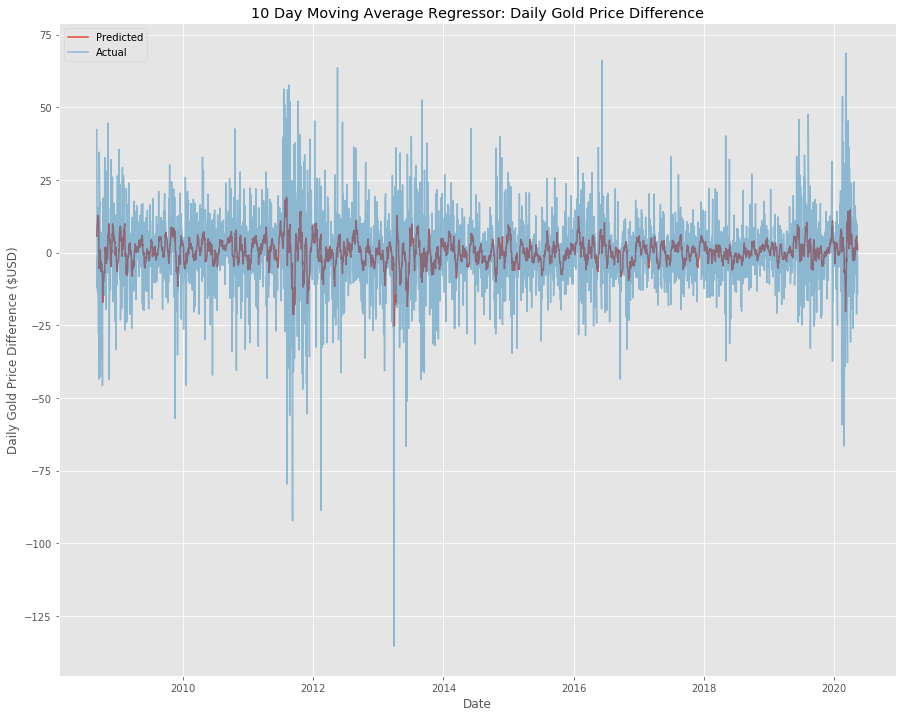

In [43]:
plot_ma_model(y_dif_ma,y_dif)

## 10 Day Moving Average Regressor: Daily Percent Change Gold Price

In [44]:
X_change_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gold_change%_lag1   3021 non-null   float64
 1   gold_change%_lag2   3021 non-null   float64
 2   gold_change%_lag3   3021 non-null   float64
 3   gold_change%_lag4   3021 non-null   float64
 4   gold_change%_lag5   3021 non-null   float64
 5   gold_change%_lag6   3021 non-null   float64
 6   gold_change%_lag7   3021 non-null   float64
 7   gold_change%_lag8   3021 non-null   float64
 8   gold_change%_lag9   3021 non-null   float64
 9   gold_change%_lag10  3021 non-null   float64
dtypes: float64(10)
memory usage: 236.1 KB


In [45]:
y_change_ma = X_change_gold.mean(axis = 1)

In [46]:
y_change = df_Xy_change['gold_change%']

In [47]:
# Since we're taking a simple moving average, we don't need to split our feature matrices. We can just compare our moving averages to actual values
train_y_change_ma = y_change_ma[:int(X_dif_gold.shape[0]*0.7)]
test_y_change_ma = y_change_ma[int(X_dif_gold.shape[0]*0.7):]


train_y_change = y_change[:int(X_dif_gold.shape[0]*0.7)]
test_y_change = y_change[int(X_dif_gold.shape[0]*0.7):]

#### Cross Validation: 10 Day Moving Average Regression Daily Percent Change Gold Price

In [86]:
ma_change_gold_score = cross_val_and_score_ma(train_y_change_ma,train_y_change,test_y_change_ma,test_y_change)

Is this moving average a classifier(enter "c") or regressor(enter "r")?r
Cross_Val 1 Model R^2 Score:-1.149
Cross_Val 2 Model R^2 Score:-1.55
Cross_Val 3 Model R^2 Score:-2.002
Cross_Val 4 Model R^2 Score:-1.323
Cross_Val 5 Model R^2 Score:-1.24
Final Model R^2 Score:-1.26


In [87]:
d_score['10 Day Moving Average Regressor: Daily Percent Change Gold Price'] = ma_change_gold_score

What is this model called?: 10 Day Moving Average Regressor: Daily Percent Change Gold Price
What is your target variable?: Daily Percent Change Gold Price


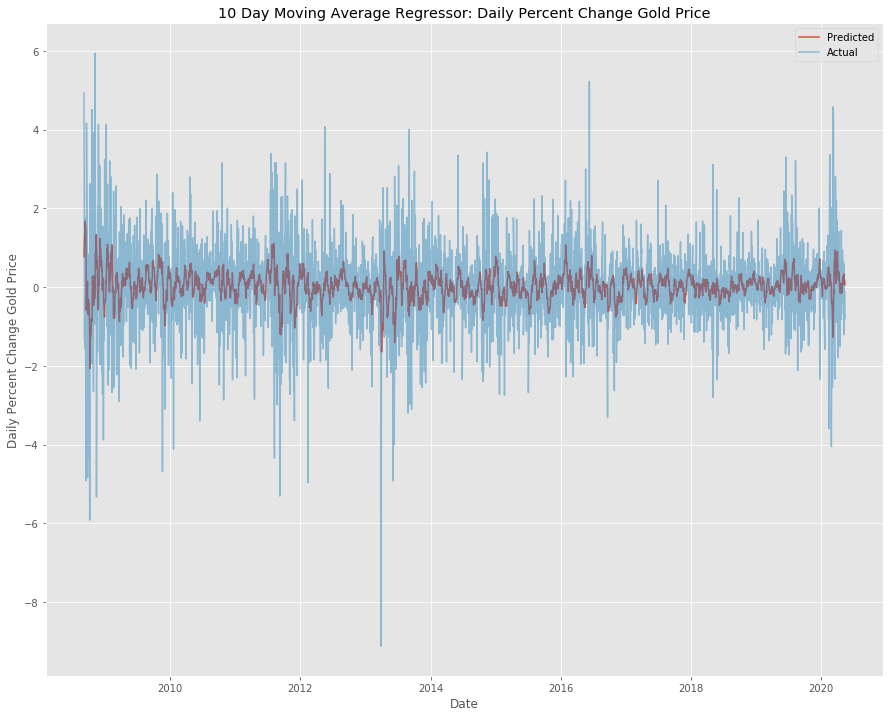

In [49]:
plot_ma_model(y_change_ma,y_change)

### 10 Day Moving Average Regressor for Gold Price Summary:
A 10 Day Moving Average Regressor also does a poor job in explaining variation in the Daily Price Difference (R^2 Score = -0.13) as well as the Daily Percent Change in Price (R^2 Score = -0.13).

#### Idea: A gradient boosting regressor comes to mind, because all of our target and feature variables are continuous, and it's evident both linear regression and moving-average models do a poor job of explaining gold's variation in price. 

## Gradient Boosting Regressor: Daily Gold Price Difference, 10 day lag

In [50]:
train_X_dif_gold = X_dif_gold[:int(X_dif_gold.shape[0]*0.7)]
test_X_dif_gold = X_dif_gold[int(X_dif_gold.shape[0]*0.7):]
train_y_dif = y_dif[:int(X_dif_gold.shape[0]*0.7)]
test_y_dif = y_dif[int(X_dif_gold.shape[0]*0.7):]

#### Cross Validation: Gradient Boosting Regressor of Daily Gold Price Difference, 10 day lag

In [88]:
dif_gold_score, dif_gold_model = cross_val_and_score(GradientBoostingRegressor(learning_rate = .01),train_X_dif_gold, test_X_dif_gold, train_y_dif, test_y_dif)

Cross_Val 1 Model R^2 Score:0.022
Cross_Val 2 Model R^2 Score:-0.02
Cross_Val 3 Model R^2 Score:-0.034
Cross_Val 4 Model R^2 Score:-0.024
Cross_Val 5 Model R^2 Score:-0.016
Final Model R^2 Score:-0.008


In [89]:
d_score['Gradient Boosting Regressor: Daily Gold Price Difference, 10 day lag'] = dif_gold_score

What is this model called?: Gradient Boosting Regressor: Daily Gold Price Difference, 10 day lag
What is your target variable?: Daily Gold Price Difference ($USD)


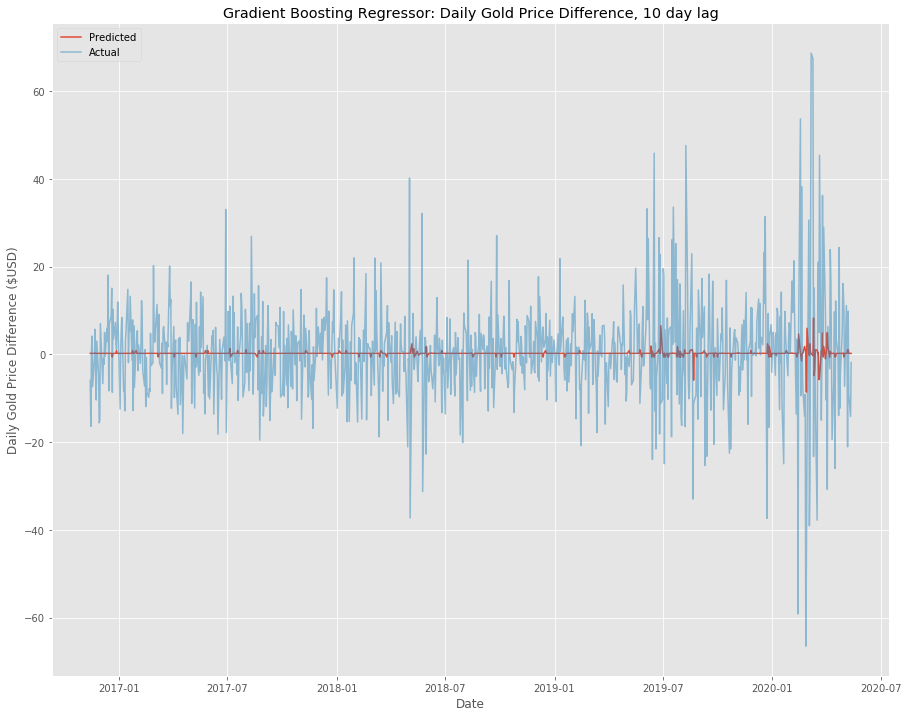

In [52]:
plot_model(dif_gold_model,test_X_dif_gold,test_y_dif)


## Gradient Boosting Regressor: Daily Percent Change Gold Price, 10 day lag

In [53]:
train_X_change_gold = X_change_gold[:int(X_change_gold.shape[0]*0.7)]
test_X_change_gold = X_change_gold[int(X_change_gold.shape[0]*0.7):]
train_y_change = y_change[:int(X_change_gold.shape[0]*0.7)]
test_y_change = y_change[int(X_change_gold.shape[0]*0.7):]

#### Cross Validation: Gradient Boosting Regressor of Daily Gold Price Difference, 10 day lag

In [54]:
change_gold_score, change_gold_model = cross_val_and_score(GradientBoostingRegressor(learning_rate = .01),train_X_change_gold, test_X_change_gold, train_y_change, test_y_change)

Cross_Val 1 Model R^2 Score:-0.011
Cross_Val 2 Model R^2 Score:-0.007
Cross_Val 3 Model R^2 Score:-0.024
Cross_Val 4 Model R^2 Score:-0.02
Cross_Val 5 Model R^2 Score:-0.018
Final Model R^2 Score:-0.005


In [90]:
d_score['Gradient Boosting Regressor: Daily Percent Change Gold Price, 10 day lag'] = change_gold_score

What is this model called?: Gradient Boosting Regressor: Daily Percent Change Gold Price, 10 day lag
What is your target variable?: Daily Percent Change Gold Price


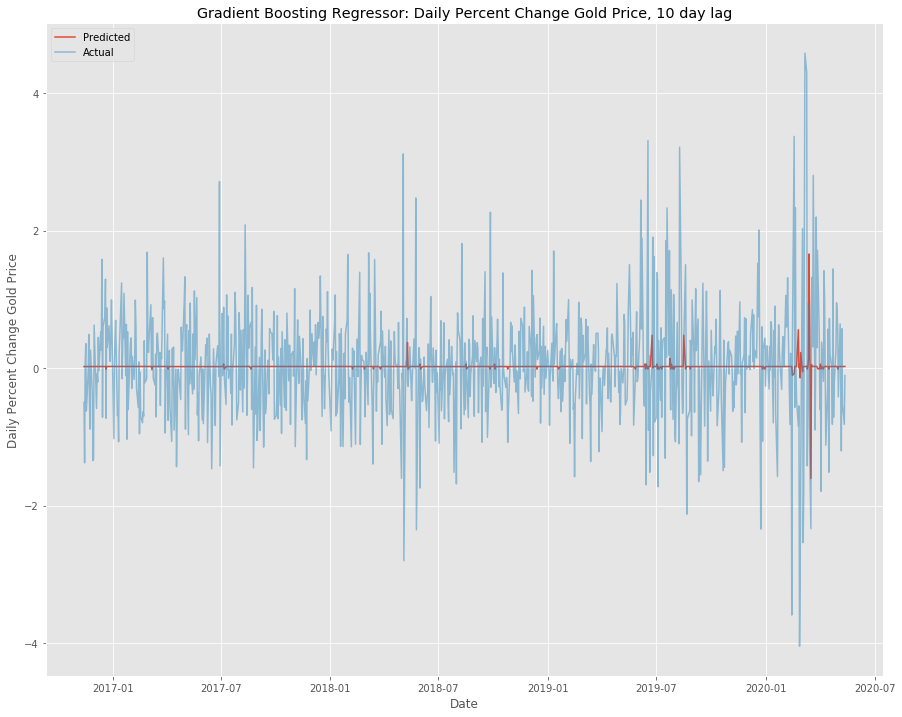

In [55]:
plot_model(change_gold_model,test_X_change_gold,test_y_change)


### Gradient Boosting Regression for Gold Price, 10 Day Lag Summary:
We only made an improvement from our Linear Model with respect to Daily Percent Change in Price (R^2 Score = -0.005).
The R^2 score for our Daily Price Difference model actually dropped a bit (R^2 Score = -0.011), 
#### Idea: Let's introduce our other features (stock market index performance, central bank policy rates, and their 10 day lags) to see if any of these metrics can help inform our model. We can use permutation importance to determine which features, if any, are most informative.

## Gradient Boosting Regressor: Daily Gold Price Difference, All Features

In [56]:
X_dif = df_Xy_dif.drop(columns = ['gold_dif','date'])
y_dif = df_Xy_dif['gold_dif']

In [57]:
X_dif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Columns: 120 entries, gbp_rate_dif to gold_dif_lag10
dtypes: float64(120)
memory usage: 2.8 MB


In [58]:
train_X_dif = X_dif[:int(X_dif.shape[0]*0.7)]
test_X_dif = X_dif[int(X_dif.shape[0]*0.7):]
train_y_dif = y_dif[:int(X_dif.shape[0]*0.7)]
test_y_dif = y_dif[int(X_dif.shape[0]*0.7):]

#### Cross Validation Gradient Boosting Regressor of Daily Gold Price Difference, All Features

In [59]:
dif_score, dif_model = cross_val_and_score(GradientBoostingRegressor(learning_rate = .01),train_X_dif, test_X_dif, train_y_dif, test_y_dif)

Cross_Val 1 Model R^2 Score:0.034
Cross_Val 2 Model R^2 Score:-0.008
Cross_Val 3 Model R^2 Score:-0.066
Cross_Val 4 Model R^2 Score:-0.194
Cross_Val 5 Model R^2 Score:-0.549
Final Model R^2 Score:-0.064


In [91]:
d_score['Gradient Boosting Regressor: Daily Gold Price Difference, All Features'] = dif_score

What is this model called?: Gradient Boosting Regressor: Daily Gold Price Difference, All Features
What is your target variable?: Daily Gold Price Difference ($USD)


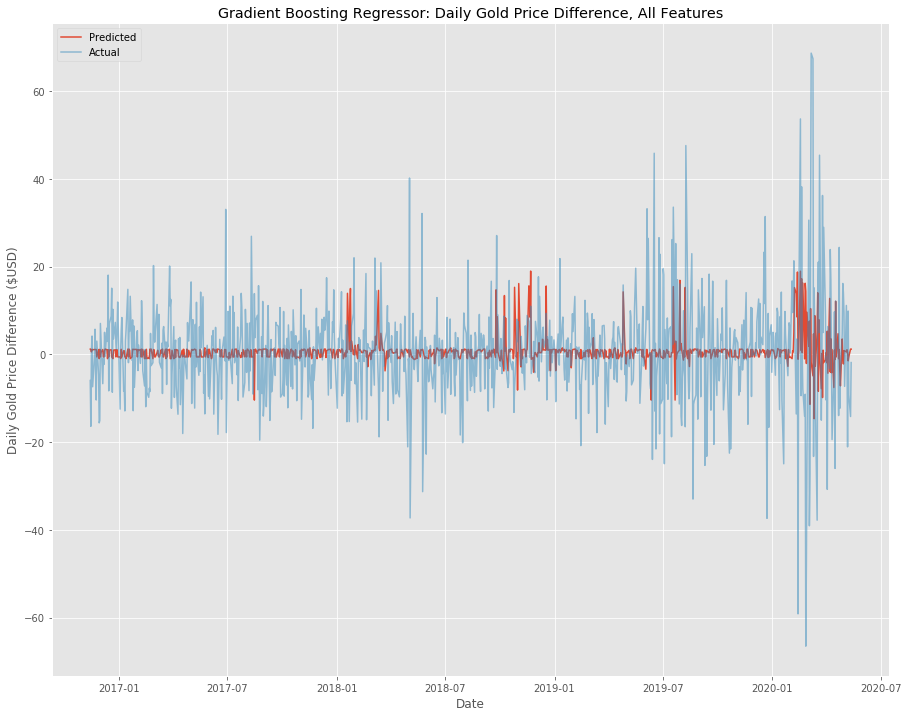

In [60]:
plot_model(dif_model,test_X_dif,test_y_dif)

## Gradient Boosting Regressor: Daily Gold Price Percent Change, All Features

In [61]:
X_change = df_Xy_change.drop(columns = ['gold_change%','date'])
y_change = df_Xy_change['gold_change%']

In [62]:
X_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Columns: 120 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(120)
memory usage: 2.8 MB


In [63]:
train_X_change = X_change[:int(X_change.shape[0]*0.7)]
test_X_change = X_change[int(X_change.shape[0]*0.7):]
train_y_change = y_change[:int(X_change.shape[0]*0.7)]
test_y_change = y_change[int(X_change.shape[0]*0.7):]

#### Cross Validation Gradient Boosting Regressor of Daily Gold Price Percent Change, All Features

In [64]:
change_score, change_model = cross_val_and_score(GradientBoostingRegressor(learning_rate = .01),train_X_change, test_X_change, train_y_change, test_y_change)

Cross_Val 1 Model R^2 Score:0.033
Cross_Val 2 Model R^2 Score:0.016
Cross_Val 3 Model R^2 Score:0.001
Cross_Val 4 Model R^2 Score:-0.048
Cross_Val 5 Model R^2 Score:-0.033
Final Model R^2 Score:-0.029


In [92]:
d_score['Gradient Boosting Regressor: Daily Gold Price Percent Change, All Features'] = change_score

What is this model called?: Gradient Boosting Regressor: Daily Gold Price Percent Change, All Features
What is your target variable?: Daily Gold Price Percent Change


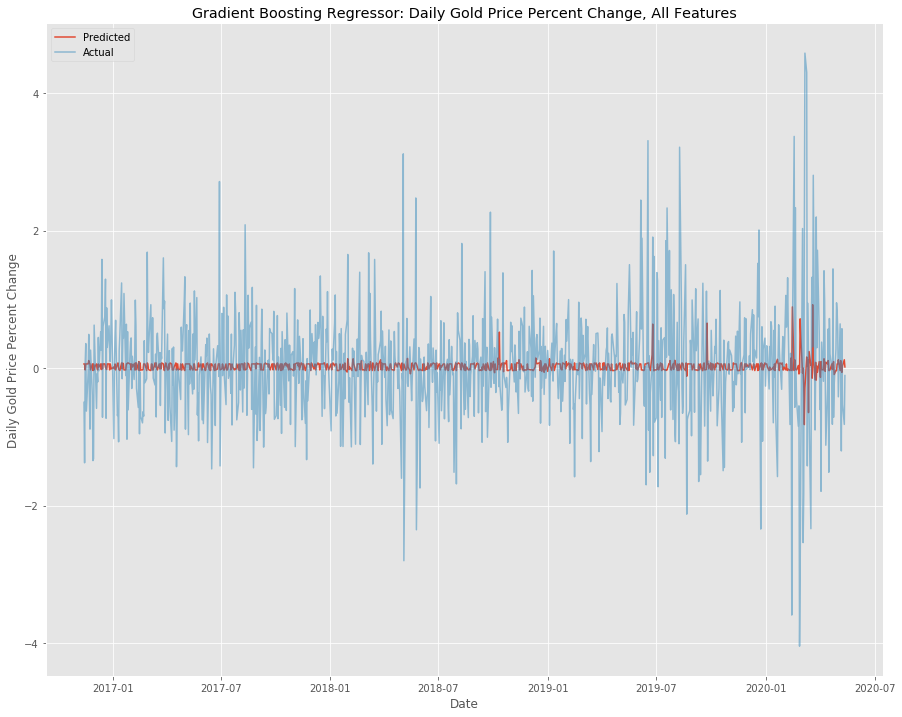

In [65]:
plot_model(change_model,test_X_change,test_y_change)


### Gradient Boosting Regression for Gold Price - Stock Indices, Central Bank Policy Rates, and Gold Pricing
Unfortunately, it looks like the introduction of more features to our models actually decreased their accuracy, making them further underform in contrast to a constant prediction: Daily Price Difference (R^2 Score = -0.078), Daily Percent Change in Price (R^2 Score = -0.028).
#### Idea: Thus far, our models have left much to be desired in terms of accuracy. They aren't explaining gold's variation in price difference or price change. However, from an investor's perspective, what is ultimately most important is whether or not the price will increase or decrease within a given time frame. Let's pivot to a classification framework and see if we can't get a better score. 


## Gradient Boosting Classifier: Daily Gold Price Difference, All Features

In [66]:
# Create boolean increase feature

X_dif = df_Xy_dif.drop(columns = ['gold_dif','date'])
y_dif = df_Xy_dif['gold_dif'] > 0

In [67]:
X_dif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Columns: 120 entries, gbp_rate_dif to gold_dif_lag10
dtypes: float64(120)
memory usage: 2.8 MB


In [68]:
train_X_dif = X_dif[:int(X_dif.shape[0]*0.7)]
test_X_dif = X_dif[int(X_dif.shape[0]*0.7):]
train_y_dif = y_dif[:int(X_dif.shape[0]*0.7)]
test_y_dif = y_dif[int(X_dif.shape[0]*0.7):]

#### Cross Validation Gradient Boosting Classifier of Daily Gold Price Difference, All Features

In [69]:
dif_score, dif_model = cross_val_and_score(GradientBoostingClassifier(learning_rate = .01),train_X_dif, test_X_dif, train_y_dif, test_y_dif)

Cross_Val 1 Model Accuracy Score:0.585
Cross_Val 2 Model Accuracy Score:0.52
Cross_Val 3 Model Accuracy Score:0.545
Cross_Val 4 Model Accuracy Score:0.486
Cross_Val 5 Model Accuracy Score:0.52
Final Model Accuracy Score:0.52


In [93]:
d_score['Gradient Boosting Classifier: Daily Gold Price Difference, All Features'] = dif_score

In [70]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [71]:
def print_confusion_matrix(model,X_test,y_test):

    """PARAMETERS:
    model - scikit learn classifier model object, fit with training data
    X_test - Test feature dataset in pandas DataFrame
    y_test - Test target dataset in pandas Series
    
    RETURNS:
    pandas Dataframe confusion matrix for the model
    """
    
    tn, fp, fn, tp = confusion_matrix(y_test,model.predict(X_test)).ravel()
    
    d_true = {'Actual Positive': [tp, fn], 'Actual Negative': [fp,tn]}
    
    df = pd.DataFrame.from_dict(d_true, orient = 'columns')
    
    df.rename(index = {0:'Predicted Positive', 1: 'Predicted Negative'}, inplace = True)
    return df

    

In [95]:
#Create confusion matrix
gb_cm_dif = print_confusion_matrix(dif_model,test_X_dif,test_y_dif)

In [96]:
gb_cm_dif

,Actual Positive,Actual Negative
Predicted Positive,315,261
Predicted Negative,174,157


## Gradient Boosting Classifier: Daily Gold Price Percent Change, All Features

In [73]:
X_change = df_Xy_change.drop(columns = ['gold_change%','date'])
y_change = df_Xy_change['gold_change%'] > 0

In [74]:
X_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Columns: 120 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(120)
memory usage: 2.8 MB


In [75]:
train_X_change = X_change[:int(X_change.shape[0]*0.7)]
test_X_change = X_change[int(X_change.shape[0]*0.7):]
train_y_change = y_change[:int(X_change.shape[0]*0.7)]
test_y_change = y_change[int(X_change.shape[0]*0.7):]

#### Cross Validation Gradient Boosting Classifier of Daily Gold Price Percent Change, All Features

In [76]:
change_score, change_model = cross_val_and_score(GradientBoostingClassifier(learning_rate = .01),train_X_change, test_X_change, train_y_change, test_y_change)

Cross_Val 1 Model Accuracy Score:0.557
Cross_Val 2 Model Accuracy Score:0.597
Cross_Val 3 Model Accuracy Score:0.562
Cross_Val 4 Model Accuracy Score:0.429
Cross_Val 5 Model Accuracy Score:0.457
Final Model Accuracy Score:0.484


In [94]:
d_score['Gradient Boosting Classifier: Daily Gold Price Percent Change, All Features'] = change_score

In [97]:
#Create confusion matrix
gb_cm_change = print_confusion_matrix(dif_model,test_X_dif,test_y_dif)

In [98]:
gb_cm_change

,Actual Positive,Actual Negative
Predicted Positive,315,261
Predicted Negative,174,157
